In [1]:
import numpy as np
import os
import pandas as pd
from scipy.io import loadmat

import matplotlib.pyplot as plt

from scipy import signal

from mne.time_frequency import psd_array_multitaper

## Dataset import


In [2]:
# Dicionário para armazenar os dados
original = {}

# Path para o file com os dados
directory = "Data_trials"

# Iterar através de cada pasta de participante
for participant_folder in os.listdir(directory):
    participant_path = os.path.join(directory, participant_folder)
    if os.path.isdir(participant_path):
        participant_number = participant_folder[1:]  # Extrair número do participante do nome da pasta

        # Iterar através dos arquivos MATLAB na pasta do participante
        for file_name in os.listdir(participant_path):
            if file_name.endswith(".mat"):
                file_path = os.path.join(participant_path, file_name)

                # Carregar arquivo MATLAB
                mat_data = loadmat(file_path)

                # Selecionar a key com o nome do file
                keys = mat_data.keys()
                key = list(keys)[3]

                # Criar DataFrame a partir dos dados; .T para transformar linhas em colunas
                df = pd.DataFrame(mat_data[key].T, columns=['TimeStamps','PO3', 'POz', 'PO4', 'O1', 'Oz', 'O2'])

                # Adicionar os dados ao dicionário usando o nome da variável como chave
                if key not in original:
                    original[key] = []
                original[key].append(df)

print(original)

{'P01_T1_R1_1': [      TimeStamps        PO3        POz        PO4        O1         Oz  \
0     123.593750   1.864631  -2.860328   1.653587 -6.425547  -3.635653   
1     123.595703   2.416753  -1.077843   2.950483 -4.994550  -1.967141   
2     123.597656   4.313347   1.916548   6.916747 -2.751511   0.732784   
3     123.599609   6.163780   4.130209  10.570951 -1.644686   2.028786   
4     123.601562   6.490129   4.432967  11.097349 -2.291279   1.016683   
...          ...        ...        ...        ...       ...        ...   
2555  128.583984  -8.472112 -14.553066  -4.899053 -3.590019  -4.270864   
2556  128.585938 -10.756668 -17.010790  -7.277852 -7.278764  -7.616994   
2557  128.587891 -12.720378 -18.316055  -9.205285 -9.548800 -10.001910   
2558  128.589844 -11.026507 -16.585035  -8.335190 -8.101057  -8.968301   
2559  128.591797  -6.623455 -12.930046  -5.479271 -4.359848  -5.893701   

            O2  
0     4.468567  
1     5.550319  
2     7.454867  
3     8.273323  
4     7.0

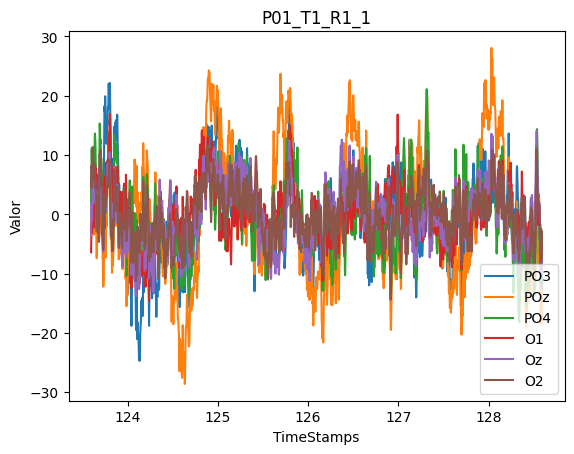

In [3]:
# Plotar gráficos relativos apenas um gráfico do ensaio 1 do teste 1 do paciente 1
for key, dfs in original.items():
    if key == "P01_T1_R1_1":
        plt.title(f'{key}')
        for data in dfs:
            # Plotar cada estado (relativa a cada coluna)
            for channel in data.columns[1:]:
                plt.plot(data[data.columns[0]], data[channel], label=channel)
        plt.xlabel('TimeStamps')
        plt.ylabel('Valor')
        plt.legend()
        plt.show()

In [4]:
# Cálculo da frequência de amostragem

data = original['P01_T1_R1_1'][0]

time_diff = data['TimeStamps'].diff().mean()

fs = 1 / time_diff

print("Sampling frequency =", fs, "Hz")

Sampling frequency = 512.0 Hz


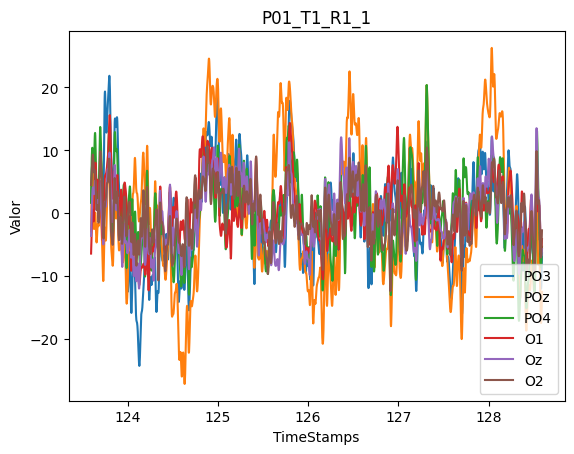

{'P01_T1_R1_1': [      TimeStamps        PO3        POz       PO4        O1        Oz        O2
  0     123.593750   1.829212  -2.925473  1.607176 -6.464189 -3.652478  4.443051
  1     123.595703   2.971921  -0.935467  3.688615 -5.434323 -2.579384  4.930862
  2     123.597656   4.104147   0.986787  5.644273 -4.399329 -1.517896  5.443311
  3     123.599609   5.200707   2.752604  7.354271 -3.368946 -0.480652  5.998872
  4     123.601562   6.225483   4.271904  8.723307 -2.367730  0.515210  6.601733
  ...          ...        ...        ...       ...       ...       ...       ...
  2555  128.583984 -11.568719 -17.165237 -8.004897 -6.176078 -6.849333 -6.198906
  2556  128.585938 -10.662499 -16.376800 -7.438694 -5.860718 -6.748249 -5.455534
  2557  128.587891  -9.412646 -15.249874 -6.781392 -5.366654 -6.484803 -4.595109
  2558  128.589844  -7.945472 -13.930324 -6.081352 -4.772038 -6.126921 -3.680393
  2559  128.591797  -6.401870 -12.570432 -5.376536 -4.157338 -5.744371 -2.763889
  
  [2560 ro

In [5]:
# Definição dos parâmetros do lowpass filter
sos = signal.iirfilter(8, 40, btype='lowpass', analog=False, ftype='butter', fs=fs, output='sos')

#Aplicação de um notch filter para remover frequências de 50 Hz (ruído)
notch_freq = 50.0 
quality_factor = 20.0

b_notch, a_notch = signal.iirnotch(notch_freq, quality_factor, fs)

#Dataframe com os dados filtrados
filtrado= {}

#Aplicação do low pass filter
for key, dfs in original.items():
    filtrado[key] = []
    for df in dfs:
        timestamps = df['TimeStamps']
        df_without_timestamps = df.drop(columns=['TimeStamps'])
        df_filtrado = pd.DataFrame(signal.sosfiltfilt(sos, df_without_timestamps.values, axis=0), columns=df_without_timestamps.columns)
        df_filtrado = pd.concat([timestamps, df_filtrado], axis=1)
        filtrado[key].append(df_filtrado)

#Aplicação do notch filter
for key, dfs in filtrado.items():
    for df in dfs:
        for column in df.columns[1:]:
            df[column] = signal.filtfilt(b_notch, a_notch, df[column])


# Plotar gráficos relativos apenas um gráfico do ensaio 1 do teste 1 do paciente 1
for key, dfs in filtrado.items():
    if key == "P01_T1_R1_1":
        plt.title(f'{key}')
        for data in dfs:
            # Plotar cada estado (relativa a cada coluna)
            for channel in data.columns[1:]:
                plt.plot(data[data.columns[0]], data[channel], label=channel)
        plt.xlabel('TimeStamps')
        plt.ylabel('Valor')
        plt.legend()
        plt.show()
filtrado

### CCA new

In [6]:
# import necessary libralies
import numpy as np
import pandas as pd
import scipy.io
from scipy.io import loadmat
import matplotlib.pyplot as plt


In [16]:
# Labeling
labels = {}
for key in filtrado.keys():
    patient_id, _, _, frequency = key.split('_')
    labels[key] = int(frequency)

print(labels)

# Convert labels to single-element arrays
labels_array = {key: np.array([label]) for key, label in labels.items()}

Y= labels_array

print(labels)


{'P01_T1_R1_1': 1, 'P01_T1_R1_2': 2, 'P01_T1_R1_3': 3, 'P01_T1_R1_4': 4, 'P01_T1_R1_5': 5, 'P01_T1_R1_6': 6, 'P01_T1_R2_1': 1, 'P01_T1_R2_2': 2, 'P01_T1_R2_3': 3, 'P01_T1_R2_4': 4, 'P01_T1_R2_5': 5, 'P01_T1_R2_6': 6, 'P01_T1_R3_1': 1, 'P01_T1_R3_2': 2, 'P01_T1_R3_3': 3, 'P01_T1_R3_4': 4, 'P01_T1_R3_5': 5, 'P01_T1_R3_6': 6, 'P01_T1_R4_1': 1, 'P01_T1_R4_2': 2, 'P01_T1_R4_3': 3, 'P01_T1_R4_4': 4, 'P01_T1_R4_5': 5, 'P01_T1_R4_6': 6, 'P02_T1_R1_1': 1, 'P02_T1_R1_2': 2, 'P02_T1_R1_3': 3, 'P02_T1_R1_4': 4, 'P02_T1_R1_5': 5, 'P02_T1_R1_6': 6, 'P02_T1_R2_1': 1, 'P02_T1_R2_2': 2, 'P02_T1_R2_3': 3, 'P02_T1_R2_4': 4, 'P02_T1_R2_5': 5, 'P02_T1_R2_6': 6, 'P02_T1_R3_1': 1, 'P02_T1_R3_2': 2, 'P02_T1_R3_3': 3, 'P02_T1_R3_4': 4, 'P02_T1_R3_5': 5, 'P02_T1_R3_6': 6, 'P02_T1_R4_1': 1, 'P02_T1_R4_2': 2, 'P02_T1_R4_3': 3, 'P02_T1_R4_4': 4, 'P02_T1_R4_5': 5, 'P02_T1_R4_6': 6, 'P03_T1_R1_1': 1, 'P03_T1_R1_2': 2, 'P03_T1_R1_3': 3, 'P03_T1_R1_4': 4, 'P03_T1_R1_5': 5, 'P03_T1_R1_6': 6, 'P03_T1_R2_1': 1, 'P03_T1_R

In [8]:
# CCA constant
PI = np.pi
sampling_frequency = 512
candidate_frequency = [7, 11, 13, 17, 19, 23]
reference_signal_phase = 0

In [9]:
# Generate Reference Frequency
sin = lambda f, h, t, p: np.sin(2*PI*f*h*t + p)
cos = lambda f, h, t, p: np.cos(2*PI*f*h*t + p)
ref_wave = lambda f, h, t, p: [sin(f, h, t, p), cos(f, h, t, p)]

def generate_reference_signal_at_time(f, t, max_harmonic, phase):
    values = []
    for h in range(1, max_harmonic + 1):
        values += ref_wave(f, h, t, phase)
    return values

def generate_reference_signal(frequency, sampling_frequency, total_time, max_harmonic, phase):
    ref_signal = []
    num_time_step = total_time * sampling_frequency
    for step in range(num_time_step):
        time = step * 1/sampling_frequency
        ref_signal_at_t = generate_reference_signal_at_time(frequency, time, max_harmonic, phase)
        ref_signal.append(ref_signal_at_t)
    return ref_signal

In [10]:
# Solve for Maximum CCA from two multidimensional signal
def find_maximum_canonical_correlations(X, Y):
    if X.shape[0] == Y.shape[0]:
        N = X.shape[0]
    else:
        print('time frame is not equal')
        return None
    C_xx = 1/N * (X.T @ X)
    C_yy = 1/N * (Y.T @ Y)
    C_xy = 1/N * (X.T @ Y)
    C_yx = 1/N * (Y.T @ X)
    C_xx_inv = np.linalg.pinv(C_xx)
    C_yy_inv = np.linalg.pinv(C_yy)
    eig_values, eig_vectors = scipy.linalg.eig(C_yy_inv @ C_yx @ C_xx_inv @ C_xy)
    sqrt_eig_values = np.sqrt(eig_values)
    return max(sqrt_eig_values)

In [11]:
# Generate Reference Data
ref_signal = {}
for frequency in candidate_frequency:
    signal = generate_reference_signal(
            frequency=frequency,
            sampling_frequency=512,
            total_time=5,
            max_harmonic=3,
            phase=reference_signal_phase
    )
    ref_signal[frequency] = pd.DataFrame(signal)

In [12]:
# Function to ensure reference signal shape compatibility
def adjust_ref_signal(ref_signal):
    for key in ref_signal.keys():
        signal = ref_signal[key]
        if signal.shape == (2560, 6):
            # Reshape or process the reference signal if necessary
            ref_signal[key] = signal.T  # Transpose to shape (12, 2560) if needed
        print(f"Adjusted ref_signal[{key}] shape: {ref_signal[key].shape}")

# Adjust ref_signal to ensure correct shape
adjust_ref_signal(ref_signal)


Adjusted ref_signal[7] shape: (6, 2560)
Adjusted ref_signal[11] shape: (6, 2560)
Adjusted ref_signal[13] shape: (6, 2560)
Adjusted ref_signal[17] shape: (6, 2560)
Adjusted ref_signal[19] shape: (6, 2560)
Adjusted ref_signal[23] shape: (6, 2560)


In [13]:
def classify_cca(input_data, ref_signal, actual_freq):
    eeg_name= 1 #mudar para nome do sinal
    input_signal = pd.DataFrame(input_data)
    max_cca = {}
    for ref_signal_key in ref_signal.keys():
        ref_signal_value = ref_signal[ref_signal_key]
        print(f"Processing ref_signal_key: {ref_signal_key}, EEG: {eeg_name}")
        print(f"input_signal shape: {input_signal.shape}")
        print(f"ref_signal_value shape: {ref_signal_value.shape}")
        value = find_maximum_canonical_correlations(input_signal, ref_signal_value)
        if value.imag == 0.0:
            value = value.real
        else:
            value = 0
            print(f"No correlation found for ref_signal_key: {ref_signal_key}")
        max_cca[ref_signal_key] = value
    max_cca["result"] = max(max_cca.items(), key = lambda x: x[1])[0]
    max_cca["actual_freq"] = actual_freq
    return max_cca

In [14]:
import numpy as np

# Assuming filtrado is already defined as your dictionary
data_list = []

# Iterate through each key in the filtrado dictionary
for key in filtrado:
    # Extract the dataframe from the list in the dictionary
    df = filtrado[key][0]

    # Extract the required columns
    required_columns = df[['PO3', 'POz', 'PO4', 'O1', 'Oz', 'O2']]

    # Append the extracted columns to the data list
    data_list.append(required_columns.values.T)  # Transpose to get shape (6, 2560)

# Convert the list to a numpy array and reshape
data_array = np.array(data_list).reshape(-1, 6, 2560)

print(data_array.shape)  # Should print (840, 6, 2560)

data_array= data_array[:6]
import numpy as np

# Assuming labels is already defined as your dictionary
# Initialize an empty list for the Y array
y_list = []

# Iterate through the labels dictionary
for key, label in labels.items():
    # Append the key and label as a tuple to the list
    y_list.append([key, label])

# Convert the list to a numpy array
y_array = np.array(y_list)

print(y_array.shape)  # Should print (840, 2)
print(y_array[:5])    # Print first 5 entries to check

y_labels_array = np.array(list(labels.values()))

y_labels_array=y_labels_array[:18]

print(y_labels_array.shape)  # Should print (840,)
print(y_labels_array[:10])   # Print first 10 entries to check


# Check the shapes
print(f"data_array shape: {data_array.shape}")  # Should print (840, 6, 2560)
print(f"y_labels_array shape: {y_labels_array.shape}")  # Should print (840,)

# Check for None or invalid values in y_labels_array
if np.any(y_labels_array == None):
    print("y_labels_array contains None values")
else:
    print("y_labels_array is valid")

# Validate the contents of data_array
valid_data = True
for i in range(data_array.shape[0]):
    if data_array[i].shape != (6, 2560):
        print(f"Invalid shape at index {i}: {data_array[i].shape}")
        valid_data = False
    if np.any(np.isnan(data_array[i])):
        print(f"NaN values found at index {i}")
        valid_data = False
    if np.any(np.isinf(data_array[i])):
        print(f"Inf values found at index {i}")
        valid_data = False


(840, 6, 2560)
(840, 2)
[['P01_T1_R1_1' '1']
 ['P01_T1_R1_2' '2']
 ['P01_T1_R1_3' '3']
 ['P01_T1_R1_4' '4']
 ['P01_T1_R1_5' '5']]
(18,)
[1 2 3 4 5 6 1 2 3 4]
data_array shape: (6, 6, 2560)
y_labels_array shape: (18,)
y_labels_array is valid


In [15]:
result = {}
result['training'] = []
# result['testing'] = []
for window_index in range(data_array.shape[0]):
    result['training'].append(
        classify_cca(data_array[window_index,:,:], ref_signal, y_labels_array[window_index])
    )
    # result['testing'].append(
    #     classify_cca(X_test_sw[window_index,:,:], ref_signal, y_test_cf[window_index])
    # )
training_result = pd.DataFrame(result['training'])
# testing_result = pd.DataFrame(result['testing'])

Processing ref_signal_key: 7, EEG: 1
input_signal shape: (6, 2560)
ref_signal_value shape: (6, 2560)
Processing ref_signal_key: 11, EEG: 1
input_signal shape: (6, 2560)
ref_signal_value shape: (6, 2560)


KeyboardInterrupt: 

In [ ]:
# print("Result from training data of subject", labels_array[0])
sum_correct = np.sum(training_result['result'] == training_result["actual_freq"])
acc_tr = sum_correct / len(training_result['result'].values)
print("Correct frequencies: {} from total: {}".format(sum_correct, len(training_result['result'])))
print("The accuracy is:", acc_tr)
training_result

### CCA inicial

In [ ]:
# import numpy as np
# import pywt
# from scipy.signal import welch
# from scipy.stats import entropy

# def extract_features(df):
#     features = []
    
#     # Statistical Features
#     means = np.mean(df, axis=0)
#     variances = np.var(df, axis=0)
    
#     # Frequency-domain Features
#     f, psd = welch(df, axis=0)  # Power spectral density
#     max_power_freqs = f[np.argmax(psd, axis=0)]  # Frequency with max power
#     spectral_entropies = entropy(psd.T)  # Spectral entropy
    
#     # Time-domain Features
#     autocorrs = []
#     for i in range(df.shape[1]):  # Iterate over columns (channels) of the DataFrame
#         autocorr = np.correlate(df.iloc[:, i], df.iloc[:, i], mode='full')  # Autocorrelation for each channel
#         autocorrs.append(autocorr)
    
#     zero_crossing_rates = np.sum(np.diff(np.sign(df), axis=0) != 0, axis=0) / (df.shape[0] - 1)  # Zero-crossing rate
    
#     # Wavelet Transform Coefficients
#     coeffs = pywt.dwt(df, 'db1', axis=0)
#     wavelet_features = np.concatenate((coeffs[0], coeffs[1]), axis=1)  # Concatenate approximation and detail coefficients

#     # Print dimensions for debugging
#     print("means shape:", means.shape)
#     print("variances shape:", variances.shape)
#     print("max_power_freqs shape:", max_power_freqs.shape)
#     print("spectral_entropies shape:", spectral_entropies.shape)
#     print("autocorrs shapes:", [autocorr.shape for autocorr in autocorrs])
#     print("zero_crossing_rates shape:", zero_crossing_rates.shape)
#     print("wavelet_features shape:", wavelet_features.shape)
    
#     # Concatenate all features into a single vector for each sample
#     for i in range(df.shape[0]):  # Iterate over rows (samples) of the DataFrame
#         sample_autocorrs = []
#         for j in range(len(autocorrs)):
#             if autocorrs[j][i].size > 0:
#                 sample_autocorrs.append(autocorrs[j][i])
#         sample_autocorrs_filtered = [autocorr for autocorr in sample_autocorrs if autocorr.size > 0]
#         if sample_autocorrs_filtered:
#             sample_autocorrs = np.concatenate(sample_autocorrs_filtered)
#         else:
#             sample_autocorrs = np.array([])

#         sample_features = np.concatenate([means, variances, max_power_freqs, spectral_entropies, sample_autocorrs, [zero_crossing_rates[i]], wavelet_features[i]])
#         features.append(sample_features)
    
#     return np.array(features)


    
    






# def extract_features(df):
#     features = []
    
#     # Statistical Features
#     means = np.mean(df, axis=0)
#     variances = np.var(df, axis=0)
#     skewnesses = skew(df, axis=0)
#     kurtoses = kurtosis(df, axis=0)
    
#     # Frequency-domain Features
#     f, psd = welch(df, axis=0)  # Power spectral density
#     max_power_freqs = f[np.argmax(psd, axis=0)]  # Frequency with max power
#     spectral_entropies = entropy(psd.T)  # Spectral entropy
    
#     # Time-domain Features
#     autocorrs = []
#     for i in range(df.shape[1]):  # Iterate over columns (channels) of the DataFrame
#             autocorr = np.correlate(df.iloc[:, i], df.iloc[:, i], mode='full')  # Autocorrelation for each channel
#             autocorrs.append(autocorr)
#     zero_crossing_rates = np.sum(np.diff(np.sign(df), axis=0) != 0, axis=0) / (df.shape[0] - 1)  # Zero-crossing rate
    
#     # Wavelet Transform Coefficients
#     coeffs = pywt.dwt(df, 'db1', axis=0)
#     wavelet_features = np.concatenate((coeffs[0], coeffs[1]), axis=1)  # Concatenate approximation and detail coefficients
    
#     # Combine all features
#     features.extend([means, variances, skewnesses, kurtoses, max_power_freqs, spectral_entropies])
#     features.extend(autocorrs)
#     features.append(zero_crossing_rates)
#     features.append(wavelet_features)
    
#     return features


# Example usage:
# features = extract_features(df)
# # Nonlinear Features (you may need to install the `nolds` library for these)
    # from nolds import entropy as approximate_entropy, lyap_e
    # approximate_entropies = [approximate_entropy(channel, 2, 0.2 * np.std(channel)) for channel in df.T]
    # lyapunov_exponents = lyap_e(df.T, emb_dim=10, matrix_dim=4)
    # features.append(approximate_entropies)
    # features.append(lyapunov_exponents)

In [ ]:
import numpy as np
from scipy.signal import welch

def extract_features(df):
    features = []
    
    # Statistical Features
    means = np.mean(df, axis=0)
    variances = np.var(df, axis=0)
    
    # Frequency-domain Features
    f, psd = welch(df, axis=0)  # Power spectral density
    max_power_freqs = f[np.argmax(psd, axis=0)]  # Frequency with max power
    
    # Time-domain Features
    zero_crossing_rates = np.sum(np.diff(np.sign(df), axis=0) != 0, axis=0) / (df.shape[0] - 1)  # Zero-crossing rate
    
    # Calculate zero-crossing rate per sample (assuming it's a scalar)
    zero_crossing_rate = np.mean(zero_crossing_rates)
    
    # Concatenate the selected features into a single vector for each sample
    for i in range(df.shape[0]):  # Iterate over rows (samples) of the DataFrame
        sample_features = np.concatenate([means, variances, max_power_freqs, [zero_crossing_rate]])
        features.append(sample_features)
    
    return np.array(features)


In [ ]:
# Feature Extraction for Entire 5s Window
features_5s = {}
for key, dfs in filtrado.items():
    features_5s[key] = []
    for df in dfs:
        # Extract features from the entire 5s window
        window_data = df.iloc[:, 1:]  # Exclude the timestamps
        if window_data.shape[0] == 2560:  # Entire 5s window
            feature = extract_features(window_data)
            features_5s[key].append(feature)
print(features_5s)

# Feature Extraction for Middle 4s Window
features_4s = {}
for key, dfs in filtrado.items():
    features_4s[key] = []
    for df in dfs:
        # Extract features from the middle 4s window
        window_data = df.iloc[:, 1:]  # Exclude the timestamps
        if window_data.shape[0] == 2560:  # Middle 4s window
            start_index = (2560 - 2048) // 2
            end_index = start_index + 2048
            window_data = window_data.iloc[start_index:end_index, :]
            feature = extract_features(window_data)
            features_4s[key].append(feature)

#print(features_4s)

In [ ]:
# Get the size of the features matrix
sizes = []
for key, features in features_5s.items():
    sizes.append((key, np.array(features).shape))

# Print the sizes
for key, size in sizes:
    print(f"Patient {key}: {size}")

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import CCA

# Prepare X and Y matrices
X = np.concatenate([features_5s[key] for key in features_5s], axis=0)
Y = np.concatenate([labels_array[key] for key in labels_array], axis=0)

# Ensure X and Y have the same number of samples
assert X.shape[0] == Y.shape[0], "Number of samples in X and Y matrices must match"

# Reshape X to 2D array
X_reshaped = X.reshape(X.shape[0], -1)

# Standardize X and Y
scaler_X = StandardScaler()
scaler_Y = StandardScaler()

X_reshaped = scaler_X.fit_transform(X_reshaped)
Y = Y.reshape(-1, 1)  # Ensure Y is 2D
Y = scaler_Y.fit_transform(Y)

print(f"New shape of X: {X_reshaped.shape}")
print(f"Shape of Y: {Y.shape}")

# Perform CCA
cca = CCA(n_components=1)  # Number of canonical components to extract
cca.fit(X_reshaped, Y)

# Get canonical variables
X_c, Y_c = cca.transform(X_reshaped, Y)

# Canonical correlations
canonical_correlations = np.corrcoef(X_c[:, 0], Y_c[:, 0])[0, 1]

# Print canonical correlations
print("Canonical Correlations:", canonical_correlations)

# Do further analysis with X_c and Y_c...


In [ ]:
import matplotlib.pyplot as plt

# Plot the canonical variables
plt.figure(figsize=(10, 6))
plt.scatter(X_c, Y_c, alpha=0.5)
plt.xlabel('Canonical Variable 1 (X)')
plt.ylabel('Canonical Variable 1 (Y)')
plt.title('Canonical Variables from CCA')
plt.show()


In [ ]:
from sklearn.cross_decomposition import CCA

# Perform regularized CCA
cca = CCA(n_components=1, scale=True, max_iter=500, tol=1e-06)
cca.fit(X_reshaped, Y)

# Get canonical variables
X_c, Y_c = cca.transform(X_reshaped, Y)

# Canonical correlations
canonical_correlations = np.corrcoef(X_c[:, 0], Y_c[:, 0])[0, 1]

# Print canonical correlations
print("Regularized Canonical Correlations:", canonical_correlations)


In [ ]:
from sklearn.decomposition import PCA

# Apply PCA to reduce dimensionality
pca = PCA(n_components=100)  # Adjust the number of components as needed
X_reduced = pca.fit_transform(X_reshaped)

# Perform CCA on reduced data
cca = CCA(n_components=1)
cca.fit(X_reduced, Y)

# Get canonical variables
X_c, Y_c = cca.transform(X_reduced, Y)

# Canonical correlations
canonical_correlations = np.corrcoef(X_c[:, 0], Y_c[:, 0])[0, 1]

# Print canonical correlations
print("Canonical Correlations after PCA:", canonical_correlations)
